# Image classification dataset: CIFAR10

In this homework, we will be using a couple of datasets. The bigger one is this Image classification dataset: CIFAR10.

The [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks. Such a situation is called **multiclass** classification in oppose to **multilabel** classification when each example may have multiple label.

One can see state-of-the-art results [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)

## Prepare the notebook

In [6]:
from IPython.core.debugger import Pdb as pdb
import _pickle as cPickle
import tarfile

import numpy as np
import pandas as pd

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Set style for plotting

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

## Set a random seed for reproducibility

In [3]:
np.random.seed(42)

# Upack the Data and do EDA (exploratory data analysis)
In this section we unpack the CIFAR-10 Data set and do some exploratory data analysis

Unarchive data

In [4]:
tar = tarfile.open("/Users/ayeshabhimdiwala/I526_AML_FA18/Assignments/Unit-02_KNN_CIFAR10/data/cifar-10-python.tar.gz", "r:gz")
tar.extractall("data")
tar.close()

## Load the data

Data are stored as a memory dump with python $\text{dict}$ object. It was created using **pickle** function. To read one should "unpickle" it.

In [4]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo, encoding='latin1')
    fo.close()
    return dict

Data are also splitted in to 5 pieces for conveniece. Let's read them all and concatenate

In [6]:
for b in range(1, 6):
    data_batch = unpickle("data/cifar-10-batches-py/data_batch_" + str(b))
    if b == 1:
        X_train = data_batch["data"]
        y_train = np.array(data_batch["labels"])
    else:
        X_train = np.append(X_train, data_batch["data"], axis=0)
        y_train = np.append(y_train, data_batch["labels"], axis=0)

Read test data. In this dataset train/test split is provided by authors of the dataset to be able to consistently evaluate solutions

In [7]:
data_batch = unpickle("data/cifar-10-batches-py/test_batch")
X_test = data_batch["data"]
y_test = np.array(data_batch["labels"])

Read meta-information file with the names of the classes

In [49]:
classes = unpickle("data/cifar-10-batches-py/batches.meta")["label_names"]

## Data engineering (pre-processing)

We have too many data

In [9]:
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 50000
Test size: 10000


### Downsample the data so we can experiment more easily
Let's downsample (common strategy to get a POC, proof of concept working) the data by taking a random sample of 10% the training and test sets. This will  allow us to do some experiments much more quickly. 

In [10]:
subsample_rate = 0.1

We want to preserve the same quantity ratio between classes. In python such an option is called **stratification**. Let's randomly (with fixed initial seed for the sake of reproducibility) divide part of train data

In [11]:
X_train, _, y_train, _ = train_test_split(X_train, y_train, stratify=y_train, train_size=subsample_rate, random_state=42)

/anaconda3/envs/i526/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


The same for test

In [12]:
X_test, _, y_test, _ = train_test_split(X_test, y_test, stratify=y_test, train_size=subsample_rate, random_state=42)

/anaconda3/envs/i526/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Indeed, we preserved the number of objects of each class

In [13]:
unique_train = np.unique(y_train, return_counts=True)
list(zip(np.array(classes)[unique_train[0]], unique_train[1]))

[('airplane', 500),
 ('automobile', 500),
 ('bird', 500),
 ('cat', 500),
 ('deer', 500),
 ('dog', 500),
 ('frog', 500),
 ('horse', 500),
 ('ship', 500),
 ('truck', 500)]

## Understand the data

For now each object has the following shape

In [14]:
X_train[0].shape

(3072,)

$3072 = 32 \times 32 \times 3$ where $32 \times 32$ is the size of the image in pixels and $3$ is the number of channels (RGB)

To show this array as an image let's reshape it in the needed from with the shape $(32, 32, 1)$

In [15]:
def show_pic(x):
    plt.imshow(x.reshape((3, 32, 32)).transpose(1, 2, 0).astype("uint8"))
    plt.axis("off")

Draw one pic from each class

In [17]:
classes_idx_examples = np.zeros(10, dtype=np.int)
for i in range(10):
    classes_idx_examples[i] = np.where(y_train == i)[0][0]

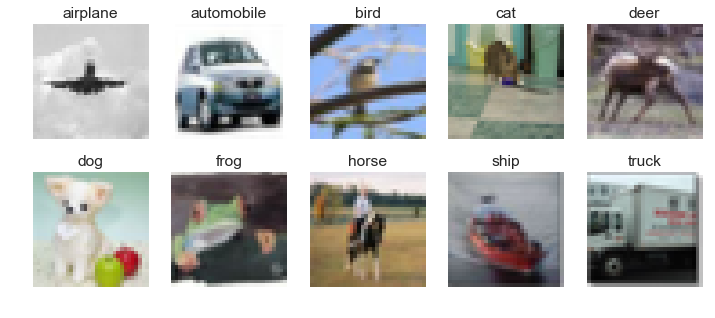

In [18]:
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_pic(X_train[classes_idx_examples[i]])
    plt.title(classes[i])

# Modeling: build a model using sci-kit learn

Let's use Sklearn implementation of algorithms to build some benchmark models for image classification.

Also one should **always** track the results of the experiments to be able to compare different approaches. Let's create pandas $\text{DataFrame}$ for this purpose.

In [19]:
results = pd.DataFrame(columns=["Model", "Test Accuracy"])

For now it is empty, but will be filled in later

In [20]:
results

,Model,Test Accuracy


## KNN

In this section the K Nearest Neighbors implementation from sklearn is presented (see theory below and in lectures)

For the beginning let's use default parametrs of KNN Sklearn classifier which are:
* $\text{n_neighbors} = 5$
* $L_2$ metric

In [21]:
# n_jobs is responsible for number of CPU cores used for computation
# -1 means use all available
model_knn_sklearn = KNeighborsClassifier(n_jobs=-1)

### Fitting

In [22]:
model_knn_sklearn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

### Evaluation

Predict answers on the test set

In [23]:
y_pred_test = model_knn_sklearn.predict(X_test)

In [24]:
print(y_pred_test)

[2 3 6 0 1 4 4 6 4 8 8 2 0 2 4 2 0 3 6 2 0 0 8 9 2 2 2 2 8 2 0 8 4 3 6 2 0
 8 2 2 0 2 2 2 8 2 0 6 4 0 6 4 2 7 4 4 3 2 2 0 4 4 2 8 8 3 8 5 4 2 4 4 4 8
 2 6 0 0 2 2 4 4 2 0 8 5 4 4 5 0 3 1 0 0 6 8 0 2 6 0 4 4 7 4 0 8 1 0 1 0 2
 2 6 2 0 4 8 6 2 6 0 0 0 8 4 6 4 4 7 4 5 2 2 0 6 4 5 9 6 4 5 6 8 0 2 0 0 8
 4 3 0 0 5 5 2 8 4 0 2 3 2 8 2 4 0 7 0 5 0 2 7 1 5 2 8 4 0 6 3 2 4 4 2 4 3
 8 8 2 2 5 2 8 2 0 2 9 2 2 0 8 8 8 5 5 8 4 6 4 2 8 4 8 6 4 3 4 0 0 5 0 6 8
 4 4 5 2 2 0 2 0 8 8 0 6 0 5 0 0 2 2 5 2 4 4 0 4 4 4 0 0 0 2 2 4 7 8 0 4 4
 2 9 0 4 4 6 0 8 4 8 6 8 4 4 4 0 2 8 4 2 8 6 2 2 8 4 7 4 4 5 4 4 4 0 2 6 4
 8 8 0 4 4 2 0 6 0 2 0 4 2 4 2 4 2 4 4 6 0 5 2 4 2 5 4 2 4 3 5 0 8 2 4 6 4
 5 6 2 2 8 5 3 4 2 2 4 0 0 4 0 0 6 0 4 4 2 4 4 6 3 7 5 4 3 5 8 4 2 0 2 0 8
 4 9 4 2 0 0 2 3 5 1 2 6 5 6 2 8 8 3 4 6 5 4 2 2 4 4 0 6 8 6 8 6 2 8 8 4 0
 2 3 2 4 8 2 0 0 2 0 4 8 4 4 8 2 8 2 4 8 8 4 4 6 0 0 0 8 4 2 4 8 2 3 1 5 0
 2 2 4 8 2 4 0 0 0 8 4 0 2 0 8 6 2 3 2 2 4 4 0 3 0 0 6 5 0 0 3 5 2 6 0 8 5
 5 0 2 4 6 4 6 0 4 4 0 8 

Accuracy score with sklearn function

In [25]:
acc = accuracy_score(y_test, y_pred_test)

Append first row to the results table

In [26]:
results.loc[len(results)] = ["KNN Arbitary Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262


### Insight into predictions

Let's take one correct prediction from test set and look onto its nearest neighbors

In [27]:
correct_idx = np.where(y_pred_test == y_test)[0][0]

Get $k$ nearest neighbors via Sklearn interface (method $\text{kneighbors}$)

In [28]:
neighbors = model_knn_sklearn.kneighbors(X=[X_test[correct_idx]], return_distance=False)[0]

Let's see what examples are

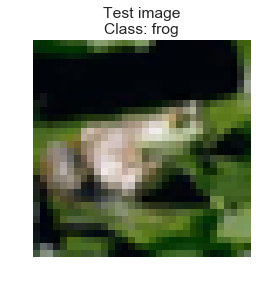

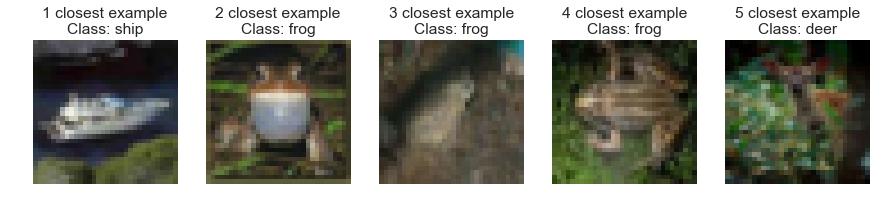

In [29]:
show_pic(X_test[correct_idx])
plt.title("Test image\nClass: " + classes[y_test[correct_idx]])
plt.show()
plt.figure(figsize=(15, 3))
for i, neighbor_idx in enumerate(neighbors):
    plt.subplot(1, 5, i + 1)
    show_pic(X_train[neighbor_idx])
    plt.title(str(i + 1) + " closest example\nClass: " + classes[y_train[neighbor_idx]])
plt.show()

Indeed, among five closest objects we have three frogs and ship pic which is very close to the initial frog pic.

It's **good** even the accuracy is bad, because our model can be explained in a very **intuitive** way

## Logistic Regression

We compare our KNN model to a model based on Multinomial Logistic Regression.
* We will learn more about this in a coming lecture.  For now, treat this as a black box classification approach.

Here we used Sklearn $\text{SGDClassifier}$ with few options:
* $\text{loss} = \text{"log"} -$corresponds to Logistic Regression
* $\text{penalty} = \text{"none"}-$ for now we don't want to use regularization (using it should impove quality by few percents)
* $\text{max_iter} = 15 -$ the number of passes over the training data (aka epochs)
* $\text{average} = 10 -$ by default Stochastic Gradient Descent method is used. This is due to the not very good approximation of gradient (only by one example). To neglect this error we simply average gradient across last 10 steps.

In [30]:
model_lr_sklearn = SGDClassifier(loss="log", penalty="none", max_iter=15, average=10, n_jobs=-1)

### Fitting

In [31]:
model_lr_sklearn.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=10, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=15, n_iter=None,
       n_jobs=-1, penalty='none', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

### Evaluation

Prediction

In [32]:
y_pred_test = model_lr_sklearn.predict(X_test)

Accuracy

In [33]:
acc = accuracy_score(y_test, y_pred_test)

Keeping table of results up-to-date

In [34]:
results.loc[len(results)] = ["LR Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.340


$7\%$ better, not bad!

# Core (Required) Assignment

In order to complete this lab successfully, please review the following lab:
* `CrossvalidationAndGridSearch-Tutorial.ipynb` from Unit 02 Labs folder.


**REMEMBER to use all of the CIFAR-10 data for Kaggle submissions (we are using only 10% of the data for experimentation)**.

## K Nearest Neighbors: Grid Search
Using the CIFAR-10 dataset and the built-in Sklearn implementation of KNN classifier, find the best set of parameters from the following range:

$$
\text{n_neighbors} \in \{1 \ldots 5\}\\
\text{p} \in \{1 \ldots 3\}
$$

where $\text{n_neighbors}$ is the number of neighbors to consider and $\text{p}$ is the order of $L_p$ metric (see explanation below)


### TASK: Sklearn  GridSearch with Cross Validation
You will need to complete the code in this section to perform a hyperparameter tuning via SKLearn's `GridSearchCV`.  Perform a grid search over the training set only. The test dataset should only be used to report your findings after you have committed to your best model(s).

In [35]:
knn_sk = KNeighborsClassifier(n_jobs=-1)

And specify the dictionary of parameters we want to optimize along with their ranges

In [36]:
n_neighbors_range = list(range(1,6))
p_range = list(range(1,4))
parameters = {'n_neighbors': n_neighbors_range, 'p': p_range}

$\text{GridSearchCV}$ function does all the stuff. There are three main arguments:
* $\text{estimator} = \text{knn_sk} -$classifier to use; KNN from sklearn defined before
* $\text{param_grid} = \text{parameters} -$parameters ranges to test
* $\text{cv} = \text{split} -$splitting iterator to use

In [43]:
%%time
best_model = GridSearchCV(estimator= knn_sk, 
                          param_grid=parameters,  
                          cv=10, 
                          refit=False,  
                          return_train_score=False,
                         verbose=2)
best_model.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] n_neighbors=1, p=1 ..............................................
[CV] ............................... n_neighbors=1, p=1, total=   4.1s
[CV] n_neighbors=1, p=1 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] ............................... n_neighbors=1, p=1, total=   4.4s
[CV] n_neighbors=1, p=1 ..............................................
[CV] ............................... n_neighbors=1, p=1, total=   4.0s
[CV] n_neighbors=1, p=1 ..............................................
[CV] ............................... n_neighbors=1, p=1, total=   4.0s
[CV] n_neighbors=1, p=1 ..............................................
[CV] ............................... n_neighbors=1, p=1, total=   4.0s
[CV] n_neighbors=1, p=1 ..............................................
[CV] ............................... n_neighbors=1, p=1, total=   4.0s
[CV] n_neighbors=1, p=1 ..............................................
[CV] ............................... n_neighbors=1, p=1, total=   3.9s
[CV] n_neighbors=1, p=1 ..............................................
[CV] ............................... n_neighbors=1, p=1, total=   4.0s
[CV] n_neighbors=1, p=1 ..............................................
[CV] .

[CV] ............................... n_neighbors=2, p=3, total=  56.7s
[CV] n_neighbors=3, p=1 ..............................................
[CV] ............................... n_neighbors=3, p=1, total=   3.9s
[CV] n_neighbors=3, p=1 ..............................................
[CV] ............................... n_neighbors=3, p=1, total=   4.0s
[CV] n_neighbors=3, p=1 ..............................................
[CV] ............................... n_neighbors=3, p=1, total=   4.0s
[CV] n_neighbors=3, p=1 ..............................................
[CV] ............................... n_neighbors=3, p=1, total=   3.9s
[CV] n_neighbors=3, p=1 ..............................................
[CV] ............................... n_neighbors=3, p=1, total=   4.0s
[CV] n_neighbors=3, p=1 ..............................................
[CV] ............................... n_neighbors=3, p=1, total=   3.9s
[CV] n_neighbors=3, p=1 ..............................................
[CV] .

[CV] ............................... n_neighbors=4, p=3, total=  57.6s
[CV] n_neighbors=4, p=3 ..............................................
[CV] ............................... n_neighbors=4, p=3, total=  56.4s
[CV] n_neighbors=4, p=3 ..............................................
[CV] ............................... n_neighbors=4, p=3, total=  57.0s
[CV] n_neighbors=5, p=1 ..............................................
[CV] ............................... n_neighbors=5, p=1, total=   4.0s
[CV] n_neighbors=5, p=1 ..............................................
[CV] ............................... n_neighbors=5, p=1, total=   4.0s
[CV] n_neighbors=5, p=1 ..............................................
[CV] ............................... n_neighbors=5, p=1, total=   4.0s
[CV] n_neighbors=5, p=1 ..............................................
[CV] ............................... n_neighbors=5, p=1, total=   3.9s
[CV] n_neighbors=5, p=1 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 54.3min finished


In [10]:
from sklearn.externals import joblib
joblib.dump(best_model, 'filename.pkl') 

NameError: name 'best_model' is not defined

In [11]:
from sklearn.externals import joblib
knn_grid = joblib.load('filename.pkl') 

Let's retrieve best parameters

In [12]:
best_p = knn_grid.best_params_["p"]
best_n = knn_grid.best_params_["n_neighbors"]
print(best_p, best_n)

1 5


### Crossfold Validation Results

In [47]:
# have a look at CV dictionary of results
knn_grid.cv_results_

{'mean_fit_time': array([0.75178878, 0.76642995, 0.76795874, 0.75099311, 0.75789576,
        0.75830102, 0.73946073, 0.76666541, 0.76019783, 0.73653803,
        0.75139031, 0.76888945, 0.76578963, 0.76722763, 0.74624617]),
 'std_fit_time': array([0.03213002, 0.00418532, 0.00461091, 0.03241942, 0.02589409,
        0.02417728, 0.065063  , 0.00605051, 0.01860556, 0.06356773,
        0.03131005, 0.00739276, 0.00386427, 0.00249752, 0.06067744]),
 'mean_score_time': array([ 3.2808239 ,  3.58225844, 56.01394365,  3.18510444,  3.52983735,
        55.57675283,  3.19869885,  3.54501164, 56.49735246,  3.21408339,
         3.53231924, 55.87417715,  3.19064639,  3.50316801, 56.81212811]),
 'std_score_time': array([0.12864237, 0.16821296, 0.55185388, 0.06256221, 0.05616727,
        0.40504903, 0.05630445, 0.05865866, 1.19792435, 0.06125299,
        0.04252931, 0.40440256, 0.01134102, 0.01053338, 1.87368085]),
 'param_n_neighbors': masked_array(data=[1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5],
    

In [15]:
print(knn_grid.cv_results_["param_n_neighbors"],)
print(knn_grid.cv_results_["param_p"], )
print(knn_grid.cv_results_["mean_test_score"], )
print(knn_grid.cv_results_["mean_fit_time"])
print(knn_grid.cv_results_["mean_score_time"])

[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5]
[1 2 3 1 2 3 1 2 3 1 2 3 1 2 3]
[0.2946 0.2802 0.2532 0.2642 0.2458 0.2224 0.2882 0.2672 0.2472 0.301
 0.2796 0.2506 0.3086 0.2778 0.251 ]
[0.75178878 0.76642995 0.76795874 0.75099311 0.75789576 0.75830102
 0.73946073 0.76666541 0.76019783 0.73653803 0.75139031 0.76888945
 0.76578963 0.76722763 0.74624617]
[ 3.2808239   3.58225844 56.01394365  3.18510444  3.52983735 55.57675283
  3.19869885  3.54501164 56.49735246  3.21408339  3.53231924 55.87417715
  3.19064639  3.50316801 56.81212811]


### TASK: Report any interesting aspect of best_model
Please report and discuss any interesting aspect of best_model dictionary (there is no wrong or right response here, but you must practice discussing your results).

* The mean test score for n=2 is the lowest among all neigbours. n=1 performs better than n=2 and n=3 which is quite surprising to me.
* The mean fit time for all the parameters is nearly the same with $\pm$0.75 units.
* Mean score time is highly dependent on the machine resources and at this point of time it is not an aspect of the model that I feel confident to look at.

### Visualize the performance metrics along each hyperparemter

/anaconda3/envs/i526/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


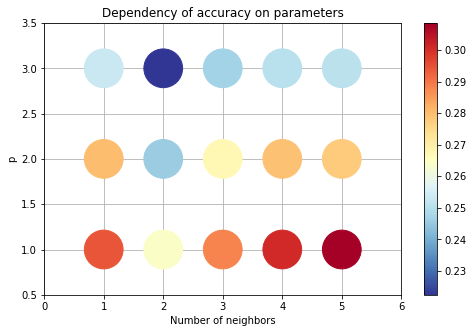

In [16]:
plt.figure(figsize=(8, 5))
sc = plt.scatter(knn_grid.cv_results_["param_n_neighbors"], 
                 knn_grid.cv_results_["param_p"], 
                 c=knn_grid.cv_results_["mean_test_score"], 
                 cmap = plt.get_cmap("RdYlBu_r"), 
                 s=1500)
plt.colorbar(sc)
plt.grid("on")
plt.gca().set_axisbelow(True)
plt.xlabel("Number of neighbors")
plt.ylabel("p")
plt.title("Dependency of accuracy on parameters")
plt.xlim([0, 6])
plt.ylim([0.5, 3.5]);

Let's choose the best $p^*$ and see how accuracy depends on the number of nearest neightbors for a KNN classifier  $p$

In [36]:
p_idx = knn_grid.cv_results_["param_p"].data == best_p

/anaconda3/envs/i526/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


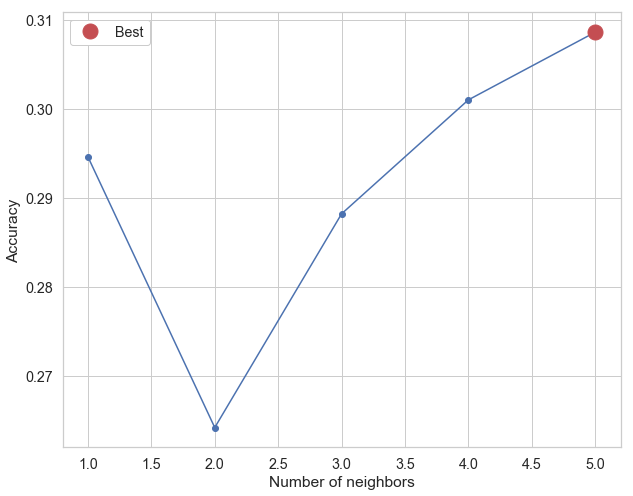

In [37]:
plt.figure(figsize=(10, 8))
plt.plot(knn_grid.cv_results_["param_n_neighbors"].data[p_idx], 
         knn_grid.cv_results_["mean_test_score"][p_idx], 
         "o-")
plt.plot([best_n], [knn_grid.cv_results_["mean_test_score"][p_idx][best_n - 1]], "or", markersize=15, label="Best")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.title("")
plt.grid("on")
plt.legend(numpoints=1)
plt.show()

Let's add this result to the table of results.  Get in the practice of always keeping a table of results.

In [38]:
acc = knn_grid.best_score_

In [53]:
results.loc[len(results)] = ["KNN Grid Search Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.340
2,KNN Grid Search Sklearn,0.309


### Sklearn Weighted KNN
In usual KNN every object from $k$ nearest neighbors is treated equally (it is called **majority voting**). But it is obvious that closer object should make bigger impact.

In this section you should not code anything again. Just see.

In [54]:
model_knn_weighted_sklearn = KNeighborsClassifier(n_jobs=-1, weights="distance", p=1, n_neighbors=3)

In [55]:
model_knn_weighted_sklearn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=1,
           weights='distance')

In [56]:
y_pred_test = model_knn_weighted_sklearn.predict(X_test)

In [57]:
acc = accuracy_score(y_test, y_pred_test)

In [58]:
results.loc[len(results)] = ["KNN Weighted Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.340
2,KNN Grid Search Sklearn,0.309
3,KNN Weighted Sklearn,0.304


You can see that the result is the better (by $1\%$) than simple KNN with Grid Search. 

### TASK - Grid search on _weighted_ KNN.
Perform a grid search over the same hyperparameters (n_neighbors and p) using weighted KNN to see if you can improve. Please add the accuracy of your best model on the test set in the table of results.

#### Building the model

In [60]:
n_neighbors_range = list(range(1,6))
p_range = list(range(1,4))
w_weights = ['distance']
parameters_weighted = {'n_neighbors': n_neighbors_range, 'weights' : w_weights,  'p': p_range}
# may be remove the weights from parameters. will know once I run :P but run this before with a really small data 

In [61]:
%%time
best_model = GridSearchCV(estimator= model_knn_weighted_sklearn, 
                          param_grid=parameters_weighted,  
                          cv=10, 
                          refit=False,  
                          return_train_score=False,
                         verbose=2)
best_model.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] n_neighbors=1, p=1, weights=distance ............................
[CV] ............. n_neighbors=1, p=1, weights=distance, total=   3.9s
[CV] n_neighbors=1, p=1, weights=distance ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] ............. n_neighbors=1, p=1, weights=distance, total=   4.2s
[CV] n_neighbors=1, p=1, weights=distance ............................
[CV] ............. n_neighbors=1, p=1, weights=distance, total=   4.4s
[CV] n_neighbors=1, p=1, weights=distance ............................
[CV] ............. n_neighbors=1, p=1, weights=distance, total=   3.9s
[CV] n_neighbors=1, p=1, weights=distance ............................
[CV] ............. n_neighbors=1, p=1, weights=distance, total=   3.9s
[CV] n_neighbors=1, p=1, weights=distance ............................
[CV] ............. n_neighbors=1, p=1, weights=distance, total=   4.0s
[CV] n_neighbors=1, p=1, weights=distance ............................
[CV] ............. n_neighbors=1, p=1, weights=distance, total=   3.8s
[CV] n_neighbors=1, p=1, weights=distance ............................
[CV] ............. n_neighbors=1, p=1, weights=distance, total=   3.9s
[CV] n_neighbors=1, p=1, weights=distance ............................
[CV] .

[CV] ............. n_neighbors=2, p=3, weights=distance, total=  56.4s
[CV] n_neighbors=3, p=1, weights=distance ............................
[CV] ............. n_neighbors=3, p=1, weights=distance, total=   3.8s
[CV] n_neighbors=3, p=1, weights=distance ............................
[CV] ............. n_neighbors=3, p=1, weights=distance, total=   3.9s
[CV] n_neighbors=3, p=1, weights=distance ............................
[CV] ............. n_neighbors=3, p=1, weights=distance, total=   3.9s
[CV] n_neighbors=3, p=1, weights=distance ............................
[CV] ............. n_neighbors=3, p=1, weights=distance, total=   3.8s
[CV] n_neighbors=3, p=1, weights=distance ............................
[CV] ............. n_neighbors=3, p=1, weights=distance, total=   3.9s
[CV] n_neighbors=3, p=1, weights=distance ............................
[CV] ............. n_neighbors=3, p=1, weights=distance, total=   3.9s
[CV] n_neighbors=3, p=1, weights=distance ............................
[CV] .

[CV] ............. n_neighbors=4, p=3, weights=distance, total=  57.7s
[CV] n_neighbors=4, p=3, weights=distance ............................
[CV] ............. n_neighbors=4, p=3, weights=distance, total=  58.0s
[CV] n_neighbors=4, p=3, weights=distance ............................
[CV] ............. n_neighbors=4, p=3, weights=distance, total=  58.0s
[CV] n_neighbors=5, p=1, weights=distance ............................
[CV] ............. n_neighbors=5, p=1, weights=distance, total=   4.0s
[CV] n_neighbors=5, p=1, weights=distance ............................
[CV] ............. n_neighbors=5, p=1, weights=distance, total=   3.9s
[CV] n_neighbors=5, p=1, weights=distance ............................
[CV] ............. n_neighbors=5, p=1, weights=distance, total=   4.0s
[CV] n_neighbors=5, p=1, weights=distance ............................
[CV] ............. n_neighbors=5, p=1, weights=distance, total=   3.9s
[CV] n_neighbors=5, p=1, weights=distance ............................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 54.7min finished


In [62]:
joblib.dump(best_model, 'filename2.pkl')  #save the model

['filename2.pkl']

#### Cross Validation Results

In [3]:
#load the model from memory
from sklearn.externals import joblib
knn_weighted = joblib.load('filename2.pkl') 

#Let's retrieve best parameters

best_p = knn_weighted.best_params_["p"]
best_n = knn_weighted.best_params_["n_neighbors"]
print(best_p, best_n)

1 5


In [39]:
# have a look at CV dictionary of results
knn_weighted.cv_results_

{'mean_fit_time': array([0.67410986, 0.66754713, 0.67472544, 0.66901324, 0.65864704,
        0.67353036, 0.67576373, 0.64712684, 0.59906032, 0.64458497,
        0.61240261, 0.63459201, 0.6393223 , 0.66305578, 0.64263282]),
 'std_fit_time': array([0.0660752 , 0.02483748, 0.00310933, 0.01601369, 0.05020183,
        0.00307274, 0.00411385, 0.05346978, 0.06185917, 0.05269789,
        0.06496935, 0.0626774 , 0.03986597, 0.04696045, 0.05840313]),
 'mean_score_time': array([ 3.34669423,  3.50600901, 55.252964  ,  3.1856153 ,  3.60901945,
        55.53726687,  3.18379529,  3.86151972, 57.58880849,  3.30921202,
         3.72951758, 57.35623195,  3.32752125,  3.6810195 , 57.58914189]),
 'std_score_time': array([0.16423833, 0.03192879, 0.3435864 , 0.04002753, 0.26600186,
        0.26564805, 0.04438749, 0.43888752, 0.68435851, 0.03005784,
        0.12202978, 0.24002297, 0.02430561, 0.06701896, 0.35538449]),
 'param_n_neighbors': masked_array(data=[1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5],
    

#### Interesting aspect of the model

* In contrast to the KNN without weight, we see here that the mean test score improves as the number of neighbors (n) increases. 
* The mean fit time when compared with regular KNN is lesser for weighted KNN which makes it a better model to run on entire training set. 

In [5]:
print(knn_weighted.cv_results_["param_n_neighbors"],)
print(knn_weighted.cv_results_["param_p"], )
print(knn_weighted.cv_results_["mean_test_score"], )
print(knn_weighted.cv_results_["param_weights"])
print(knn_weighted.cv_results_["mean_fit_time"])

[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5]
[1 2 3 1 2 3 1 2 3 1 2 3 1 2 3]
[0.2946 0.2802 0.2532 0.2946 0.2802 0.2532 0.304  0.287  0.2602 0.3176
 0.2914 0.2646 0.32   0.2962 0.2598]
['distance' 'distance' 'distance' 'distance' 'distance' 'distance'
 'distance' 'distance' 'distance' 'distance' 'distance' 'distance'
 'distance' 'distance' 'distance']
[0.67410986 0.66754713 0.67472544 0.66901324 0.65864704 0.67353036
 0.67576373 0.64712684 0.59906032 0.64458497 0.61240261 0.63459201
 0.6393223  0.66305578 0.64263282]


#### Visualizing our performance metrics

/anaconda3/envs/i526/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


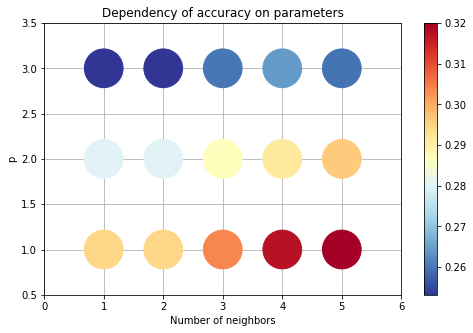

In [19]:
plt.figure(figsize=(8, 5))
sc = plt.scatter(knn_weighted.cv_results_["param_n_neighbors"], 
                 knn_weighted.cv_results_["param_p"], 
                 c=knn_weighted.cv_results_["mean_test_score"], 
                 cmap = plt.get_cmap("RdYlBu_r"), 
                 s=1500)
plt.colorbar(sc)
plt.grid("on")
plt.gca().set_axisbelow(True)
plt.xlabel("Number of neighbors")
plt.ylabel("p")
plt.title("Dependency of accuracy on parameters")
plt.xlim([0, 6])
plt.ylim([0.5, 3.5]);

Let's choose the best $p^*$ and see how accuracy depends on the number of nearest neightbors for a KNN classifier  $p$

In [45]:
p_idx_wt = knn_weighted.cv_results_["param_p"].data == best_p

/anaconda3/envs/i526/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


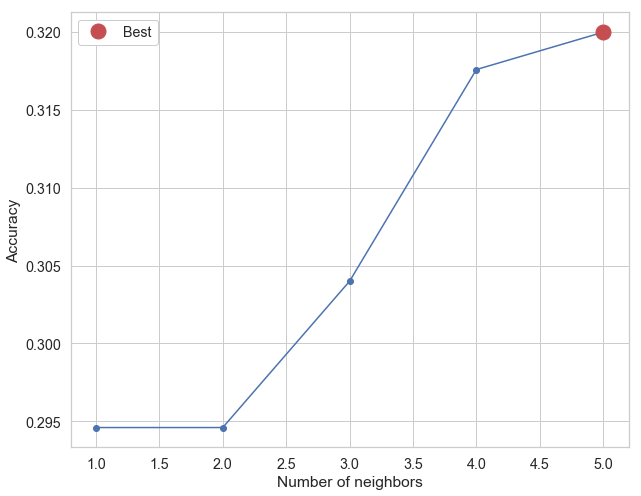

In [46]:
plt.figure(figsize=(10, 8))
plt.plot(knn_weighted.cv_results_["param_n_neighbors"].data[p_idx_wt], 
         knn_weighted.cv_results_["mean_test_score"][p_idx_wt], 
         "o-")
plt.plot([best_n], [knn_weighted.cv_results_["mean_test_score"][p_idx_wt][best_n - 1]], "or", markersize=15, label="Best")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.title("")
plt.grid("on")
plt.legend(numpoints=1)
plt.show()

In [68]:
acc = knn_weighted.best_score_

results.loc[len(results)] = ["KNN Weighted Grid Search Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.340
2,KNN Grid Search Sklearn,0.309
3,KNN Weighted Sklearn,0.304
4,KNN Weighted Grid Search Sklearn,0.320


## TASK - Do a submission to the Kaggle competition on [CIFAR](https://www.kaggle.com/c/cifar-10). 

Note that the training set in the competition is exactly the same as in this homework.  To discourage certain forms of cheating (such as hand labeling) Kaggle added 290,000 junk images in its test set. These images are ignored in the scoring, but you will need to predict labels for all 300,000 images. 

You can download the Kaggle test dataset from [this site](https://www.kaggle.com/c/cifar-10/data) in the file called test.7z. You must extract the images from this file using a .7z extractor of your choice. 

Also, do not forget to use all the CIFAR-10 data for your Kaggle submissions (previously we used just 10% of the data for experimentation).

Report your nick, rank and quality in this notebook when submitting an assignment solution. Include a screenshot of your relative position on the scoreboard. ** Please note that KNN is a poor performer on this task.**


### Running the model on Test data

#### Convert the test data to numpy array

In [48]:
from matplotlib.pyplot import imread

# load image data
X_test = []
for n in range(1,300001):
    file = '/Users/ayeshabhimdiwala/I526_AML_FA18/Assignments/Unit-02_KNN_CIFAR10/data/test/'+str((n))+'.png'
    X_test.append(imread(file).transpose(2,0,1)*255)
X_test = np.array(X_test).reshape(len(X_test),-1)


(300000, 3072)

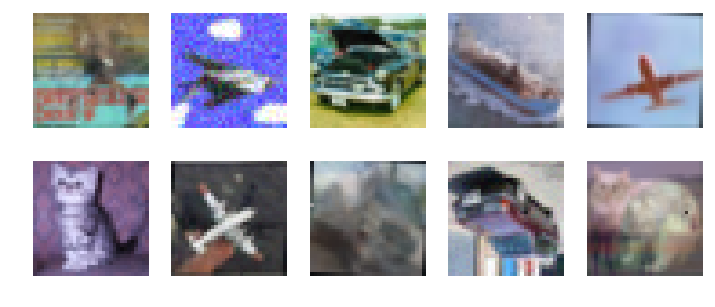

In [16]:
# view first 10 images
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_pic(X_test[i])
    
X_test.shape # we should have 300000 images with 3072 features (32,32,3).

#### Defining the best model 

I chose weighted KNN with 5 neigbours and L1 distance. The fit time for this model was comparatively less and thus I chose this model. I passed those parameters in my model for Kaggle submission with an accuracy of **39.5%.**

In [22]:
# use the best model to predict the classes
model_knn_weighted_test = KNeighborsClassifier(n_jobs=-1, weights="distance", p=1, n_neighbors=5)

In [27]:
model_knn_weighted_test.fit
X_test.shape

(300000, 3072)

#### Load the training data

In [7]:
for b in range(1, 6):
    data_batch = unpickle("data/cifar-10-batches-py/data_batch_" + str(b))
    if b == 1:
        X_train = data_batch["data"]
        y_train = np.array(data_batch["labels"])
    else:
        X_train = np.append(X_train, data_batch["data"], axis=0)
        y_train = np.append(y_train, data_batch["labels"], axis=0)
print(X_train.shape)

(50000, 3072)


#### Train the best model

In [24]:
model_knn_weighted_test.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=1,
           weights='distance')

In [29]:
y_pred_test = model_knn_weighted_test.predict(X_test)

#### Submit to kaggle after generating the labels using the code below

In [30]:
# map numerical class predictions to corresponding class labels
label_dict = {}
for n,c in enumerate(classes):
    label_dict.update({n:c})
label_preds = list(map(label_dict.get, y_pred_test)) #y_preds

# generate CSV in the form required for submission
ids = list(range(1,300001))
submission = pd.DataFrame(columns=['id','label'])
submission['id'] = ids
submission['label'] = label_preds
submission.to_csv('./submission.csv', index=False)

### Kagge Result

On Submitting to Kaggle, I got the following:
* the first image showing my submission with user name and,
* the second image with the execution time

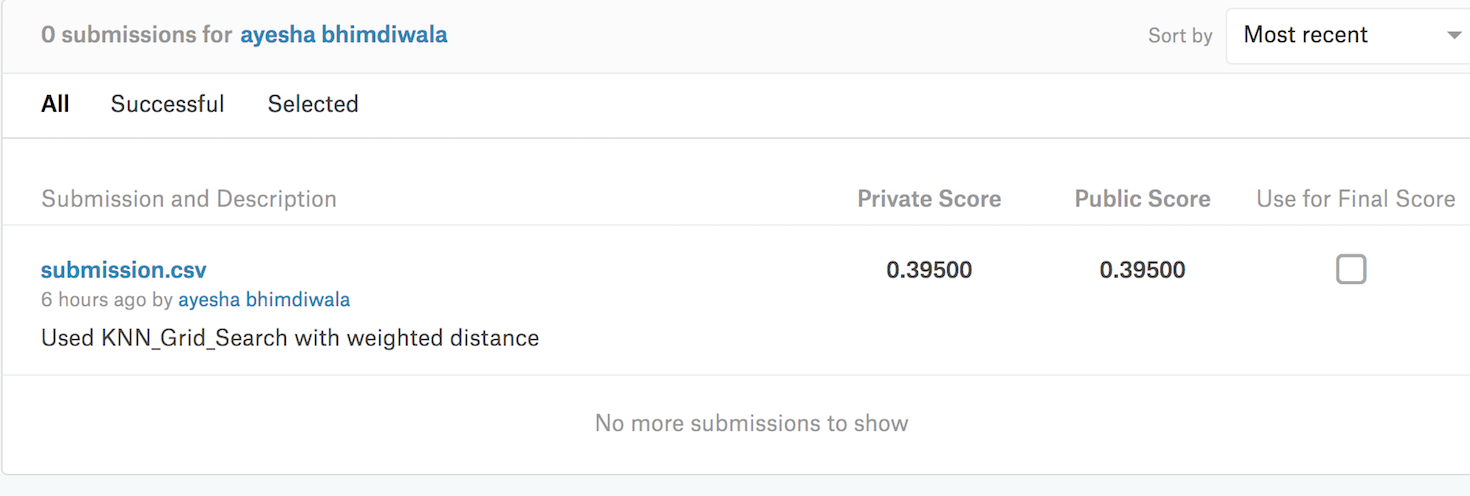

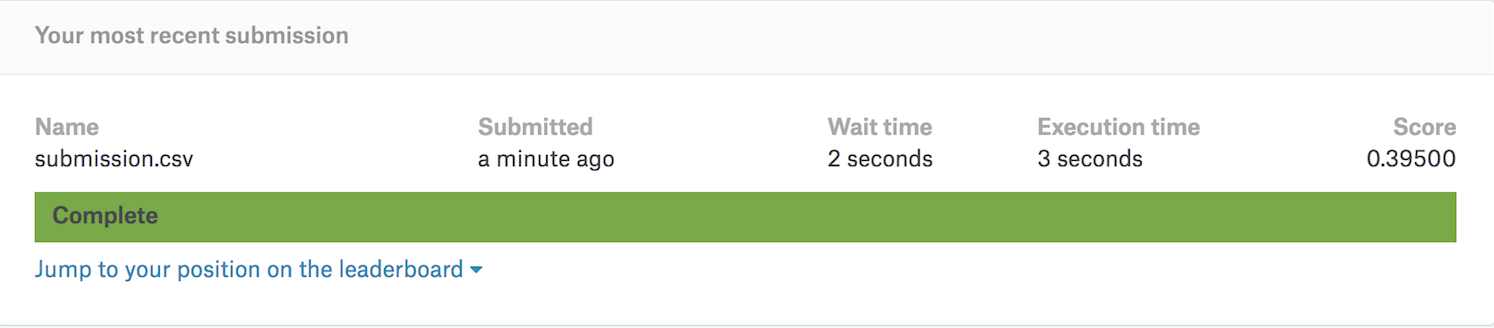